In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from typing import Union, Optional
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/ethereum-fraud-detection/data/address_data_combined_ts2.csv')

In [4]:
feature_list = list(set(df.columns) - set(['Address', 'FLAG']))
for feature in feature_list:
    print(feature)

avg val sent
adjusted_eth_value__median
Index
total ether received
adjusted_eth_value__count_above__t_0
max value received 
min value received
Time Diff between first and last (Mins)
total transactions (including tnx to create contract
adjusted_eth_value__absolute_sum_of_changes
Avg min between received tnx
adjusted_eth_value__quantile__q_0.1
adjusted_eth_value__count_below__t_0
total ether balance
Unique Received From Addresses
adjusted_eth_value__mean_abs_change
adjusted_eth_value__ratio_value_number_to_time_series_length
Avg min between sent tnx
adjusted_eth_value__sum_values
adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0
min val sent
avg val received
adjusted_eth_value__abs_energy


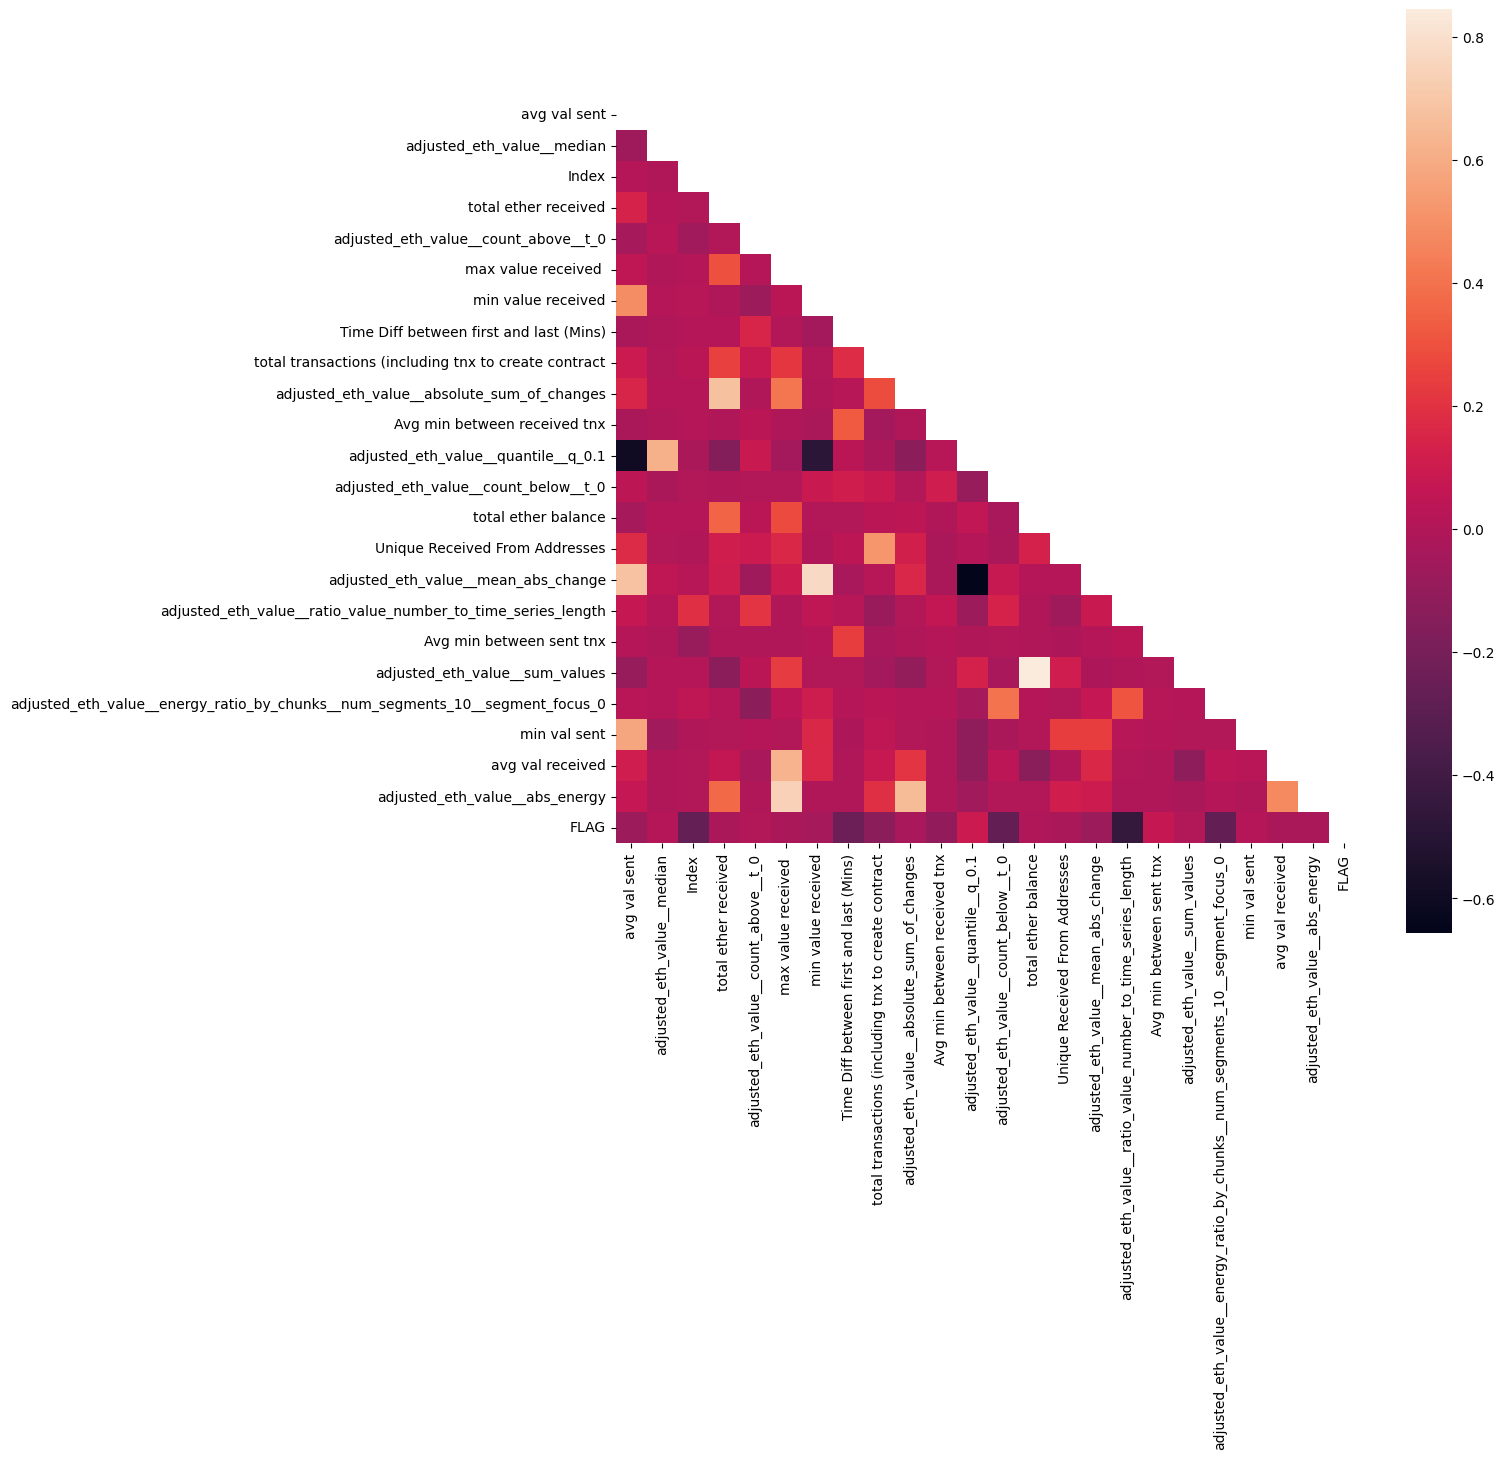

In [5]:
corr = df[feature_list + ['FLAG']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(12, 12))
sns.heatmap(data=corr, mask=mask, square=True)
plt.show()

In [6]:
df[feature_list + ['FLAG']].corr()[['FLAG']]

,FLAG
avg val sent,-0.074594
adjusted_eth_value__median,0.011328
Index,-0.264077
total ether received,-0.024179
adjusted_eth_value__count_above__t_0,0.001290
max value received,-0.027764
min value received,-0.039091
Time Diff between first and last (Mins),-0.241789
total transactions (including tnx to create contract,-0.132434
adjusted_eth_value__absolute_sum_of_changes,-0.032498


In [7]:
pairs = df[feature_list].corr().stack()
pairs_list = list(pairs[pairs.abs().gt(0.9) & pairs.abs().lt(1.0)].index)
print(int(len(pairs_list) / 2))

0


In [8]:
uniq_pairs_list = []

for x, y in pairs_list:
    if (x, y) in uniq_pairs_list or (y, x) in uniq_pairs_list:
        continue
    else:
        uniq_pairs_list.append((x, y))

In [9]:
filter_cor_feature_list =  list({x[0] for x in uniq_pairs_list})
filter_cor_feature_list

[]

In [10]:
len(list(set(feature_list) - set(filter_cor_feature_list)))

23

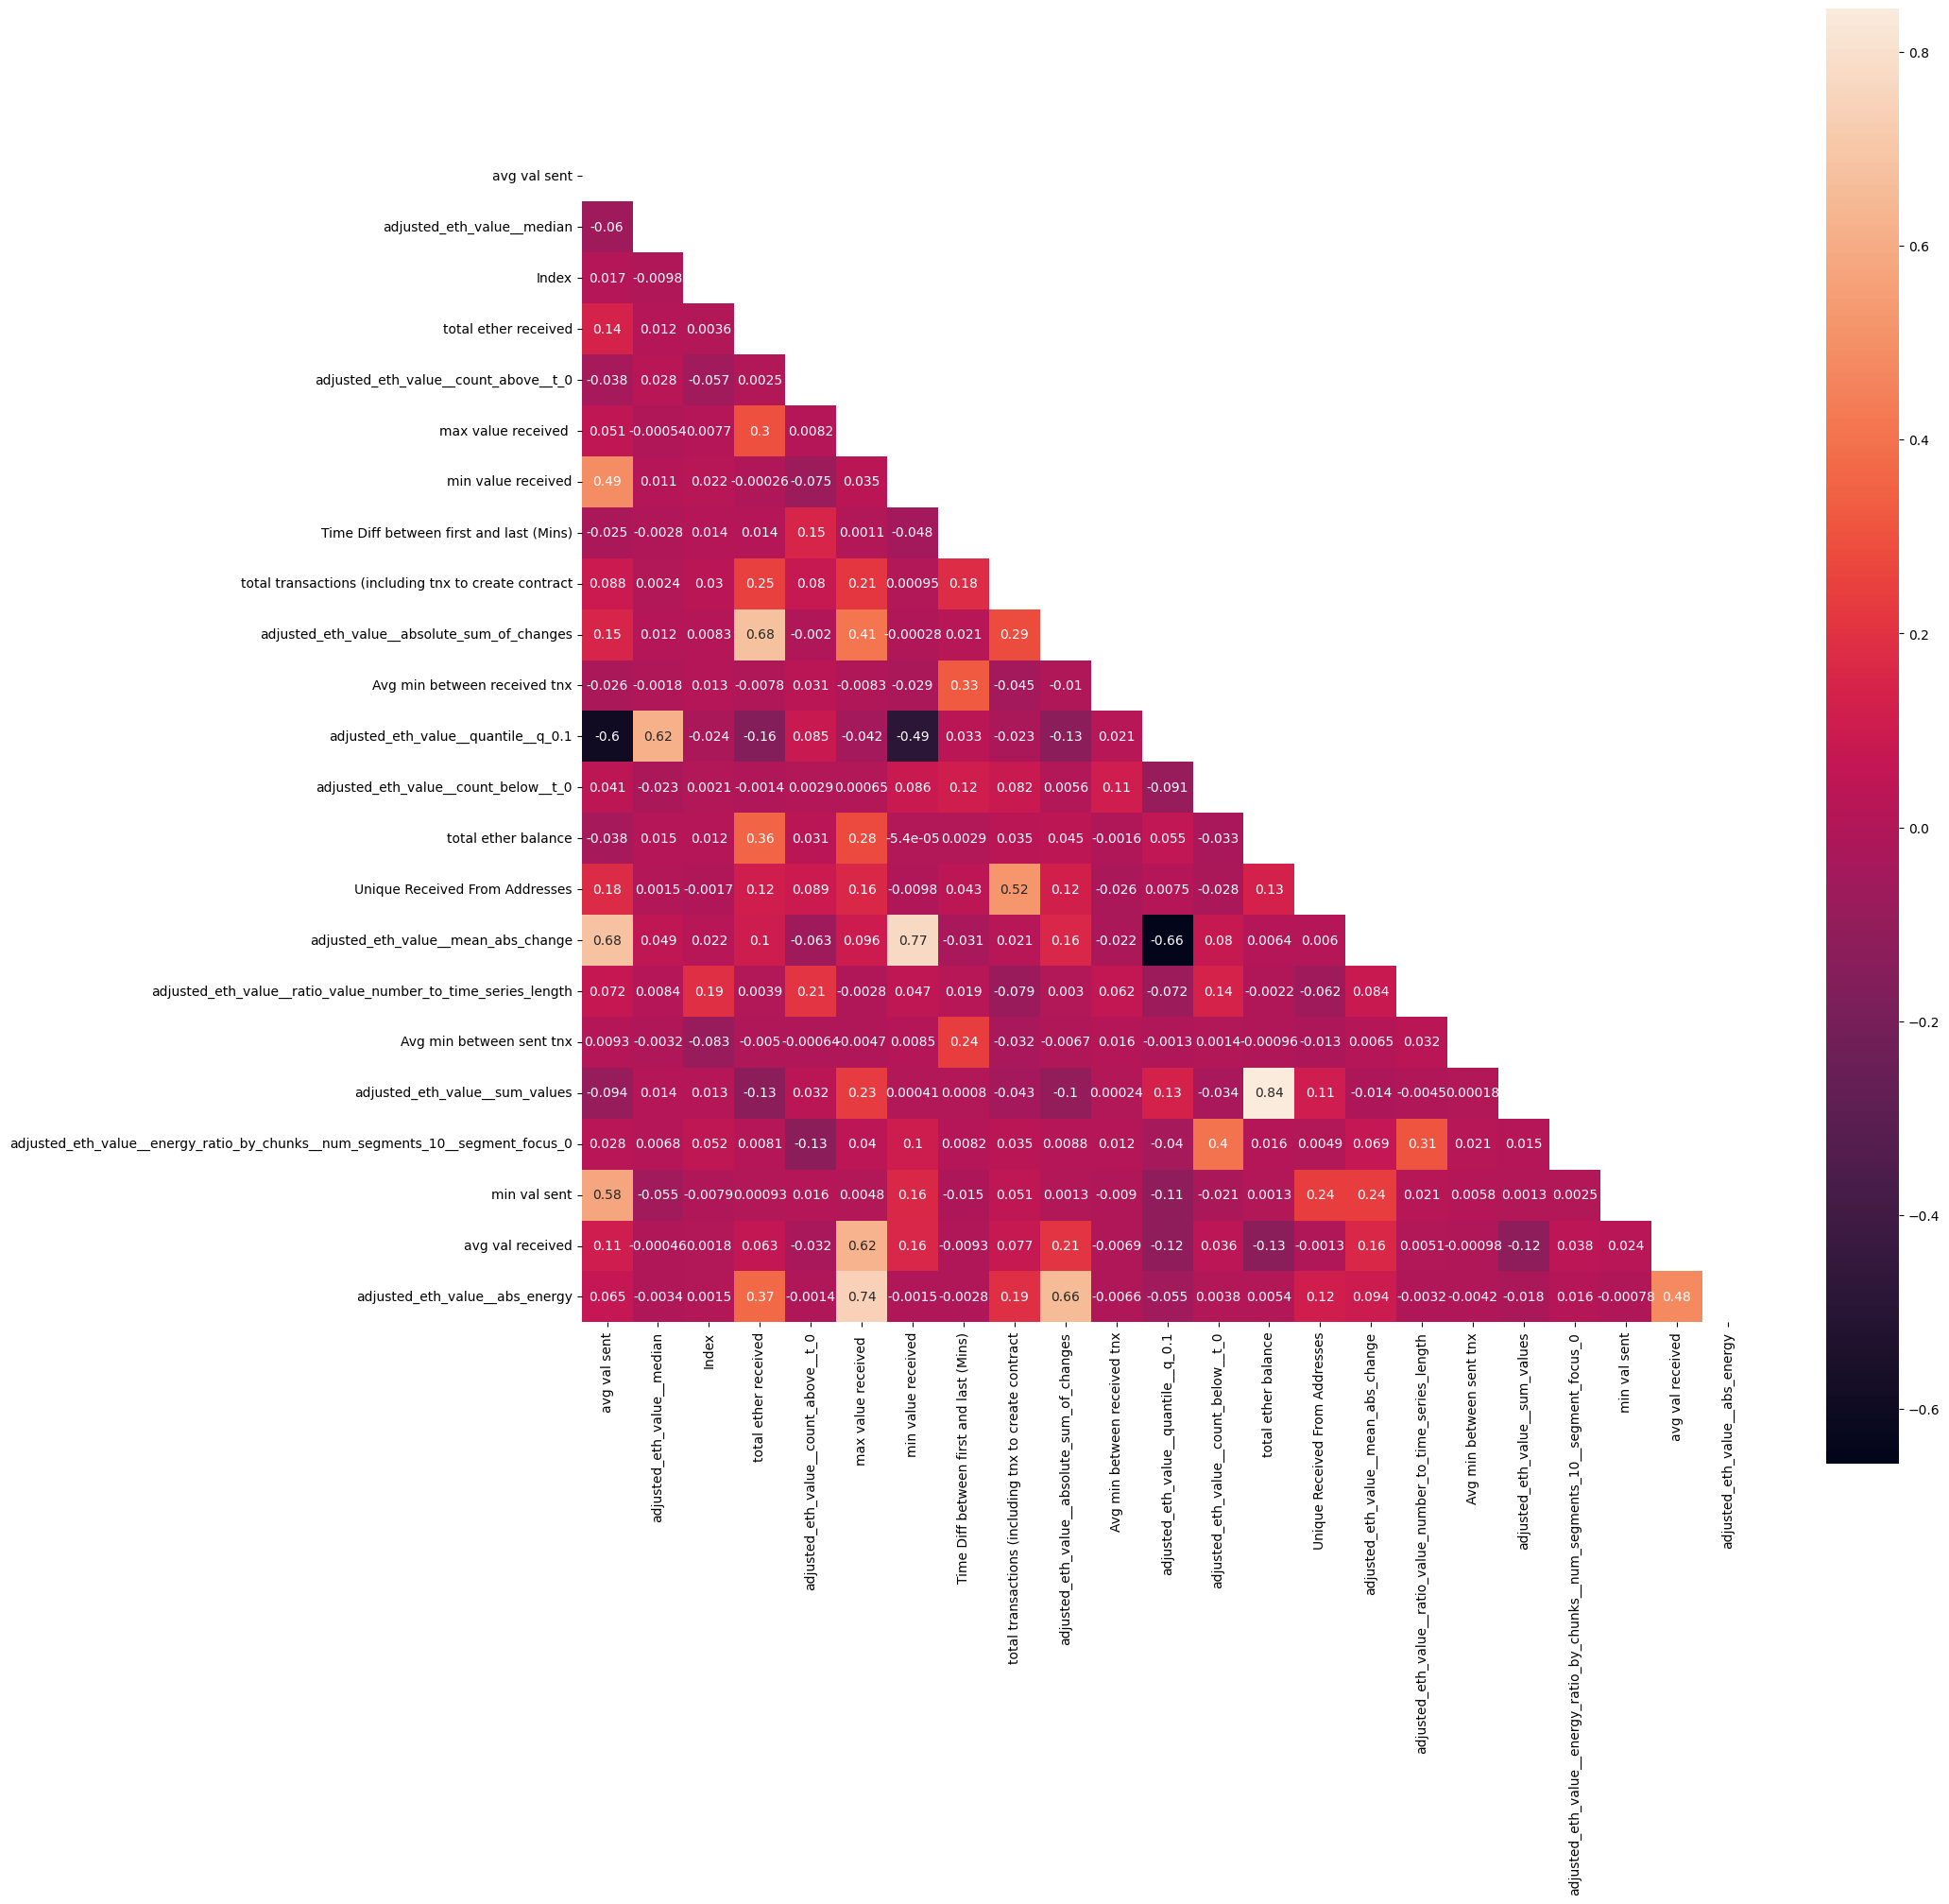

In [11]:
corr = df[list(set(feature_list) - set(filter_cor_feature_list))].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(20, 20))
sns.heatmap(data=corr, mask=mask, square=True, annot=True)
plt.show()

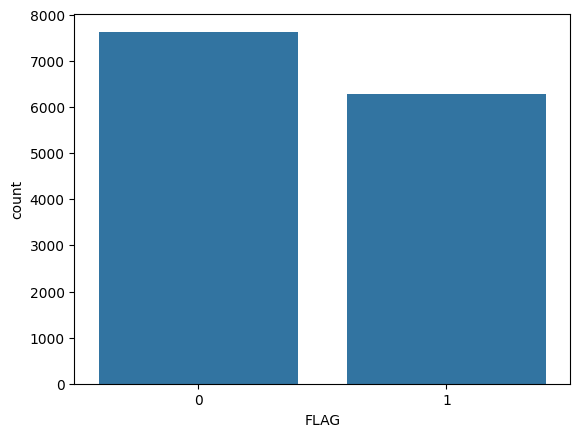

Target:  0.45136494252873566


In [12]:
sns.countplot(data=df, x='FLAG')
plt.show()
print('Target: ', df['FLAG'].mean())

In [13]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0, stratify=df['FLAG'])
df_train.shape[0], df_test.shape[0]

(12528, 1392)

In [14]:
df_train, df_valid = train_test_split(df_train, test_size=0.3, random_state=0, stratify=df_train['FLAG'])
df_train.shape[0], df_valid.shape[0]

(8769, 3759)

In [15]:
df_train['FLAG'].mean(), df_valid['FLAG'].mean(), df_test['FLAG'].mean()

(0.4513627551602235, 0.45144985368449053, 0.4511494252873563)

In [16]:
class DataPrep(BaseEstimator, TransformerMixin):
    """Implementation preprocess dataset in several strategies"""

    def __init__(self, feature_list: list,
                 drop_feature_list: Optional[list] = None,
                 fillna: Union[int, str] = 0,
                 q_up_clip_outliers: Optional[float] = None,
                 q_down_clip_outliers: Optional[float] = None):
        """
            `feature_list` - list with features name
            `drop_feature_list` - features to drop
            `fillna` - fill nans with 0, `mean` or `median` feature value
            `q_up_clip_outliers` - up quantile to clip outliers
            `q_down_clip_outliers` - down quantile to clip outliers
        """
        self.feature_list = feature_list
        self.drop_feature_list = drop_feature_list
        self.fillna = fillna
        self.q_up_clip_outliers = q_up_clip_outliers
        self.q_down_clip_outliers = q_down_clip_outliers

    def fit(self, df):
        self.fillna_dict = {}
        self.q_up_dict = {}
        self.q_down_dict = {}

        # numerical fillna fit
        if self.fillna == 'median':
            for feature in self.feature_list:
                self.fillna_dict[feature] = df[feature].median()
        elif self.fillna == 'mean':
            for feature in self.feature_list:
                self.fillna_dict[feature] = df[feature].mean()
        elif self.fillna == 0:
            for feature in self.feature_list:
                self.fillna_dict[feature] = 0
        else:
            for feature in self.feature_list:
                self.fillna_dict[feature] = None

        # numerical outliers fit
        if self.q_up_clip_outliers:
            for feature in self.feature_list:
                self.q_up_dict[feature] = df[feature].quantile(self.q_up_clip_outliers)

        if self.q_down_clip_outliers:
            for feature in self.feature_list:
                self.q_down_dict[feature] = df[feature].quantile(self.q_down_clip_outliers)


        if self.drop_feature_list:
            self.feature_list = list(set(self.feature_list) - set(self.drop_feature_list))

        return self

    def transform(self, df):

        # drop features
        if self.drop_feature_list:
            df = df.drop(columns=self.drop_feature_list)


        # numerical fillna
        for feature in self.feature_list:
            df.loc[df[feature].isna(), feature] = self.fillna_dict[feature]


        # numerical outliers
        if self.q_up_clip_outliers:
            for feature in self.feature_list:
                df.loc[df[feature] > self.q_up_dict[feature], feature] = self.q_up_dict[feature]

        if self.q_down_clip_outliers:
            for feature in self.feature_list:
                df.loc[df[feature] < self.q_down_dict[feature], feature] = self.q_down_dict[feature]


        return df

In [17]:
dp = DataPrep(
    feature_list=feature_list,
    fillna='median'
)

In [18]:
df_train_prep = dp.fit_transform(df_train)
df_valid_prep = dp.transform(df_valid)
df_test_prep = dp.transform(df_test)

In [19]:
scaler = StandardScaler()
df_train_prep = scaler.fit_transform(df_train_prep[feature_list])
df_valid_prep = scaler.transform(df_valid_prep[feature_list])
df_test_prep = scaler.transform(df_test_prep[feature_list])

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

clf = SVC(kernel='linear', probability=True)

tuned_parameters = [
    { "gamma": [1], "C": [100]},
]

clf = GridSearchCV(clf, tuned_parameters, refit=True,verbose=2,cv=5, scoring='f1')
clf.fit(df_train_prep, df_train['FLAG'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .....................................C=100, gamma=1; total time= 3.1min
[CV] END .....................................C=100, gamma=1; total time= 2.5min
[CV] END .....................................C=100, gamma=1; total time= 3.0min
[CV] END .....................................C=100, gamma=1; total time= 3.0min
[CV] END .....................................C=100, gamma=1; total time= 2.5min


GridSearchCV(cv=5, estimator=SVC(kernel='linear', probability=True),
             param_grid=[{'C': [100], 'gamma': [1]}], scoring='f1', verbose=2)

In [21]:
print(
    'train roc_auc_score: ',
    roc_auc_score(df_train['FLAG'], clf.predict_proba(df_train_prep)[:, 1])
)
print(
    'valid roc_auc_score: ',
    roc_auc_score(df_valid['FLAG'], clf.predict_proba(df_valid_prep)[:, 1])
)
print(
    'test roc_auc_score: ',
    roc_auc_score(df_test['FLAG'], clf.predict_proba(df_test_prep)[:, 1])
)

train roc_auc_score:  0.8767259929110156
valid roc_auc_score:  0.8737979443383572
test roc_auc_score:  0.8775386000600258


### Without correlated features and outliers

In [22]:
dp = DataPrep(
    feature_list=feature_list,
    fillna='median',
    q_up_clip_outliers=0.95,
    q_down_clip_outliers=0.05
)

In [23]:
df_train_prep = dp.fit_transform(df_train)
df_valid_prep = dp.transform(df_valid)
df_test_prep = dp.transform(df_test)

In [24]:
scaler = StandardScaler()
df_train_prep = scaler.fit_transform(df_train_prep[feature_list])
df_valid_prep = scaler.transform(df_valid_prep[feature_list])
df_test_prep = scaler.transform(df_test_prep[feature_list])

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [ ]:
clf = SVC(kernel='linear', probability=True)

tuned_parameters = [
    { "gamma": [1], "C": [100]},
]

clf = GridSearchCV(clf, tuned_parameters, refit=True,verbose=2,cv=5, scoring='f1')
clf.fit(df_train_prep, df_train['FLAG'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .....................................C=100, gamma=1; total time= 3.0min
[CV] END .....................................C=100, gamma=1; total time= 3.0min
[CV] END .....................................C=100, gamma=1; total time= 2.9min
[CV] END .....................................C=100, gamma=1; total time= 3.0min


In [25]:
print(
    'train roc_auc_score: ',
    roc_auc_score(df_train['FLAG'], clf.predict_proba(df_train_prep)[:, 1])
)
print(
    'valid roc_auc_score: ',
    roc_auc_score(df_valid['FLAG'], clf.predict_proba(df_valid_prep)[:, 1])
)
print(
    'test roc_auc_score: ',
    roc_auc_score(df_test['FLAG'], clf.predict_proba(df_test_prep)[:, 1])
)

train roc_auc_score:  0.9253791289521055
valid roc_auc_score:  0.9271494970013265
test roc_auc_score:  0.9358472004535299
